# Problem defintion
* To determine the most suitable crop based on given set of conditions.
* Using agro-climatic parameters, we can predict which crop is most suitable to grow.
* This will help farmers to make better decisions and get higher yields.

# Data gathering
We fetched the dataset from Kaggle practice datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

In [2]:
#Loading the dataset
crop_df=pd.read_csv("/kaggle/input/crop-recommendation-dataset/Crop_recommendation.csv")
original_crop_df=crop_df.copy()

In [3]:
#Displaying the top 5 rows
crop_df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


* Number of independent features: 7
* Number of records: 2200

In [4]:
#Fetching data object summary of the dataset
crop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


Our dataset has: -
* 4 variables of type float64.
* 3 variables of type int64.
* 1 variable of type object.

**Data dictionary: -**
1. N-> Nitrogen content in the soil (in mg/kg)
2. P-> Phosphorus content in the soil (in mg/kg)
3. K-> Potassium content in the soil (in mg/kg)
4. temperature-> Average temperature in °C
5. humidity-> Average relative humidity in %
6. ph-> Soil pH value
7. rainfall-> Rainfall in mm
8. label (target feature)-> Type of crop which is most suitable to grow

# Data quality check
Here we determine if we have any missing data and outliers in the dataset.

In [5]:
#Checking for null values in the dataset
crop_df.isna().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [6]:
crop_df.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

There are no null values in the dataset.

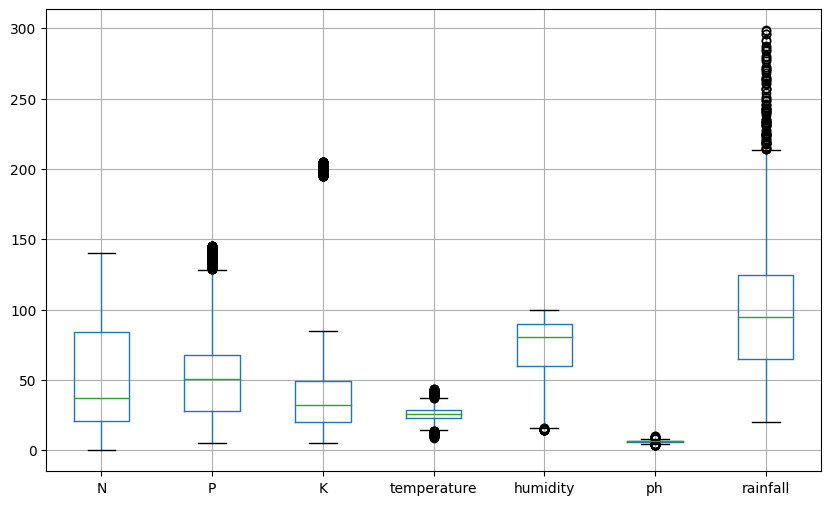

In [7]:
plt.figure(figsize=(10, 6))
crop_df[['N','P','K','temperature','humidity','ph','rainfall']].boxplot()
plt.show()

We observed outliers for following features: -
* P
* temperature
* humidity
* ph
* rainfall

# Feature distribution

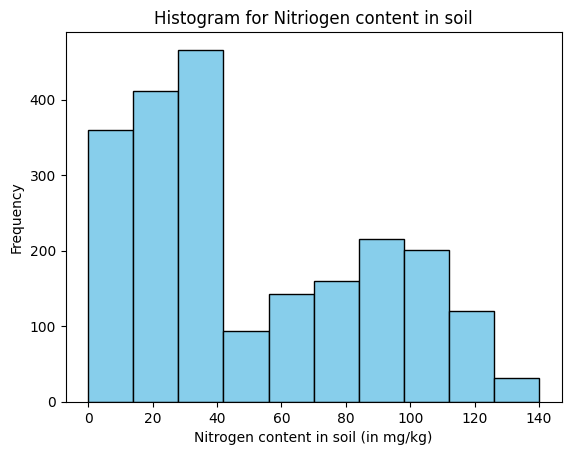

In [8]:
#Plotting histograms with default configuration
plt.hist(crop_df['N'], color='skyblue', edgecolor='black')
plt.xlabel('Nitrogen content in soil (in mg/kg)')
plt.ylabel('Frequency')
plt.title('Histogram for Nitriogen content in soil')
plt.show()

* Here we observed peak and more frequency when the Nitrogen content is lower betweeen 0 to 40.
* There is a small plateau observed for Nitrogen content between 60 to 120.

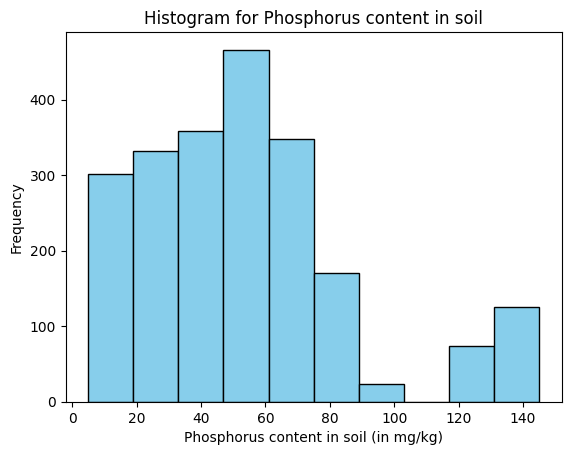

In [9]:
plt.hist(crop_df['P'], color='skyblue', edgecolor='black')
plt.xlabel('Phosphorus content in soil (in mg/kg)')
plt.ylabel('Frequency')
plt.title('Histogram for Phosphorus content in soil')
plt.show()

* Here we observed that Phosphorus content is skewed towards the left.
* Thus, there are more number of records when Phosphorus content is between 0 to 80.

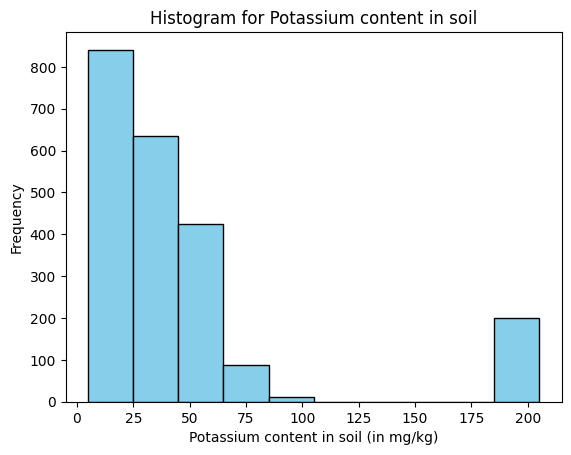

In [10]:
plt.hist(crop_df['K'], color='skyblue', edgecolor='black')
plt.xlabel('Potassium content in soil (in mg/kg)')
plt.ylabel('Frequency')
plt.title('Histogram for Potassium content in soil')
plt.show()

* We observed the distribution of Potassium content in soil is left skewed.
* Thus, there are more number of records when Potassium content is lower, between 0 to 75.
* There is a gap (missing data points) between 100 and 200.
* And we observed surge in records when Potassium content in soil is around 200.

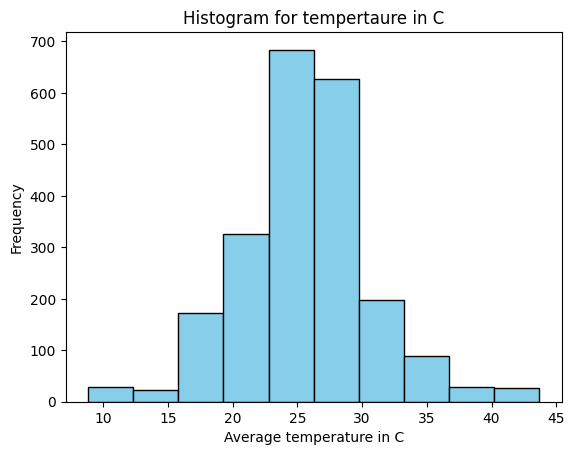

In [11]:
plt.hist(crop_df['temperature'], color='skyblue', edgecolor='black')
plt.xlabel('Average temperature in C')
plt.ylabel('Frequency')
plt.title('Histogram for tempertaure in C')
plt.show()

* The average temperature across the dataset follows Normal distribution.

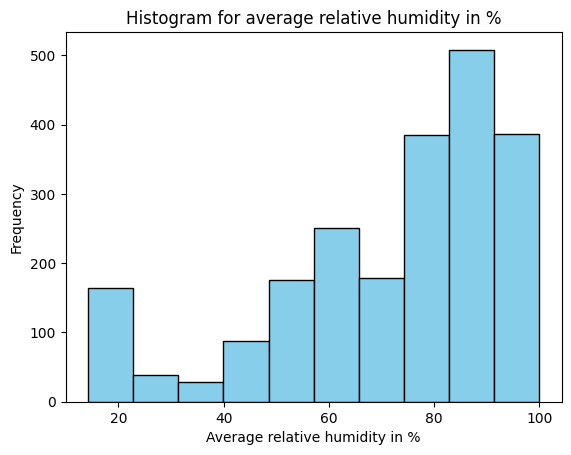

In [12]:
plt.hist(crop_df['humidity'], color='skyblue', edgecolor='black')
plt.xlabel('Average relative humidity in %')
plt.ylabel('Frequency')
plt.title('Histogram for average relative humidity in %')
plt.show()

* We observed the distribution of average relative humidity is right skewed.
* Thus, we observed more number of records with higher average relative humidity.

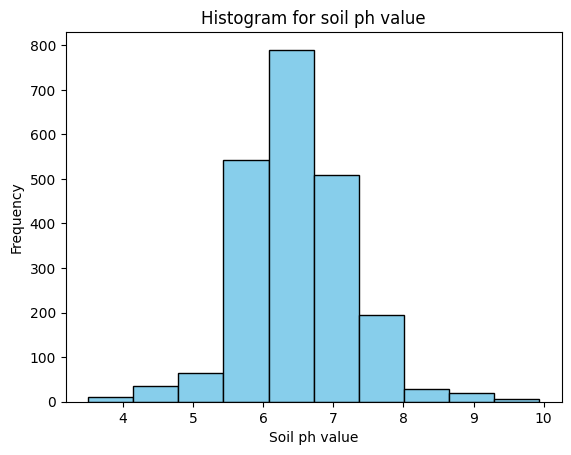

In [13]:
plt.hist(crop_df['ph'], color='skyblue', edgecolor='black')
plt.xlabel('Soil ph value')
plt.ylabel('Frequency')
plt.title('Histogram for soil ph value')
plt.show()

* The soil ph value follows Normal distribution.

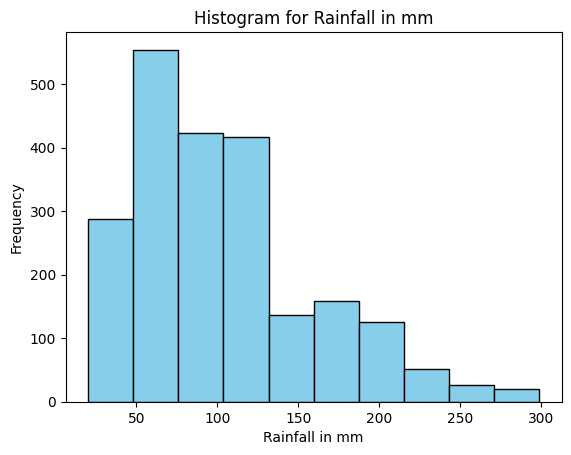

In [14]:
plt.hist(crop_df['rainfall'], color='skyblue', edgecolor='black')
plt.xlabel('Rainfall in mm')
plt.ylabel('Frequency')
plt.title('Histogram for Rainfall in mm')
plt.show()

* We observed the distribution of Rainfall in mm is left skewed.
* Thus, we observed more number of records when rainfall is less between 50 to 100 mm.

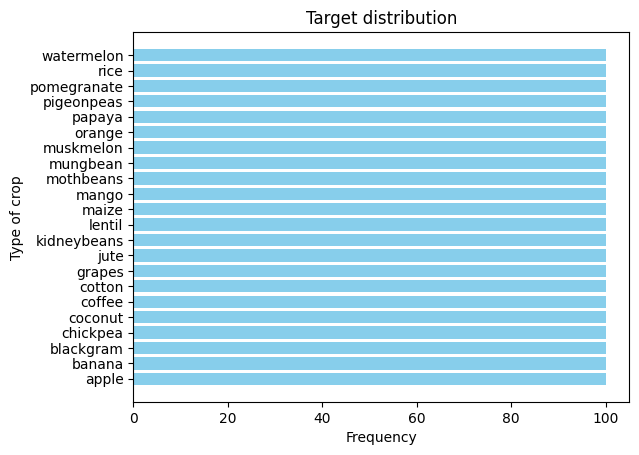

In [15]:
#Target distribution
unique_values, counts = np.unique(crop_df['label'], return_counts=True)
plt.barh(unique_values, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Type of crop')
plt.title('Target distribution')
plt.show()

* We observed all crops have equal count in the dataset = 100.
* There are 22 distinct crops listed in the dataset.
* Thus, we have a balanced dataset.

# Univariate analysis

In [16]:
crop_df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


1. **Nitrogen: N**: -
   * Mean = 50.55
   * Median = 37
   * Standard deviation = 36.91
   * Q1 quartile = 21
   * Q3 quartile = 84.25
   * Minimum = 0
   * Maximum = 140
   * Range = 140
   * Inter Quartile Range (IQR) = 63.25
   * Mean - Median > 0 : Right skewness

2. **Phosphorus: P**: -
   * Mean = 53.36
   * Median = 51
   * Standard deviation = 32.98
   * Q1 quartile = 28
   * Q3 quartile = 68
   * Minimum = 5
   * Maximum = 145
   * Range = 140
   * Inter Quartile Range (IQR) = 40
   * Mean - Median > 0 : Right skewness
     
3. **Potassium: K**: -
   * Mean = 48.14
   * Median = 32
   * Standard deviation = 50.64
   * Q1 quartile = 20
   * Q3 quartile = 49
   * Minimum = 5
   * Maximum = 205
   * Range = 200
   * Inter Quartile Range (IQR) = 29
   * Mean - Median > 0 : Right skewness
     
4. **temperature**: -
   * Mean = 25.61
   * Median = 25.59
   * Standard deviation = 5.06
   * Q1 quartile = 22.76
   * Q3 quartile = 28.56
   * Minimum = 8.82
   * Maximum = 43.67
   * Range = 34.85
   * Inter Quartile Range (IQR) = 5.8
   * Mean - Median = 0 : Normal Distribution
     
5. **humidity**: -
   * Mean = 71.48
   * Median = 80.47
   * Standard deviation = 22.26
   * Q1 quartile = 60.26
   * Q3 quartile = 89.94
   * Minimum = 14.25
   * Maximum = 99.98
   * Range = 85.73
   * Inter Quartile Range (IQR) = 29.68
   * Mean - Median < 0 : Left skewness

6. **ph**: -
   * Mean = 6.46
   * Median = 6.42
   * Standard deviation = 0.77
   * Q1 quartile = 5.97
   * Q3 quartile = 6.92
   * Minimum = 3.50
   * Maximum = 9.93
   * Range = 6.43
   * Inter Quartile Range (IQR) = 0.95
   * Mean - Median = 0 : Normal distribution

# Bivariate analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

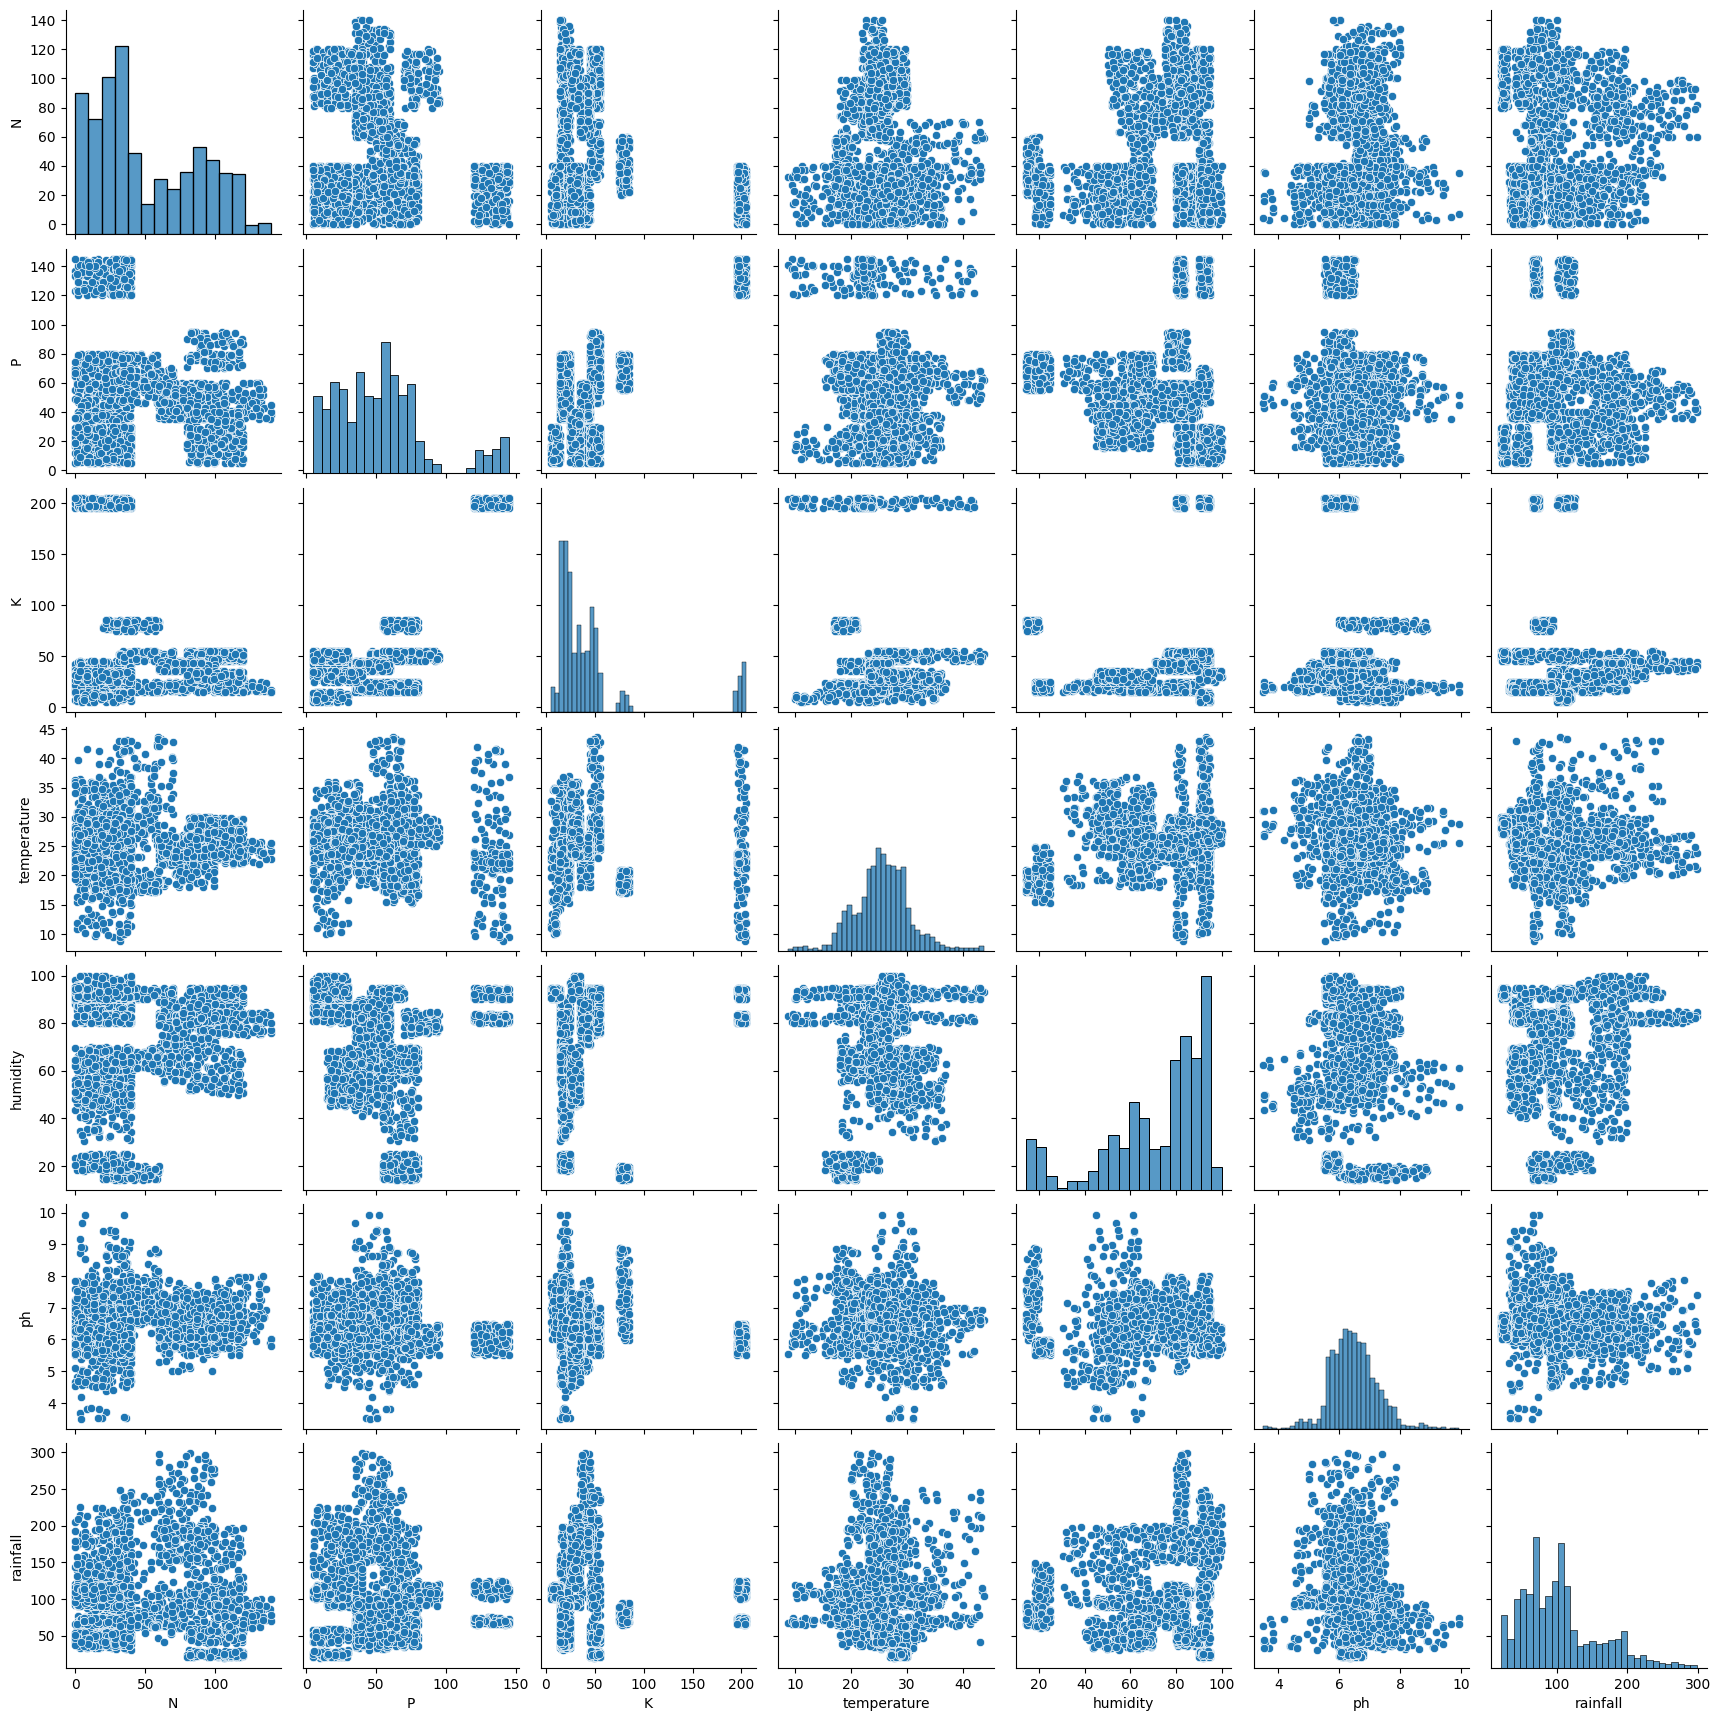

In [17]:
sns.pairplot(crop_df)

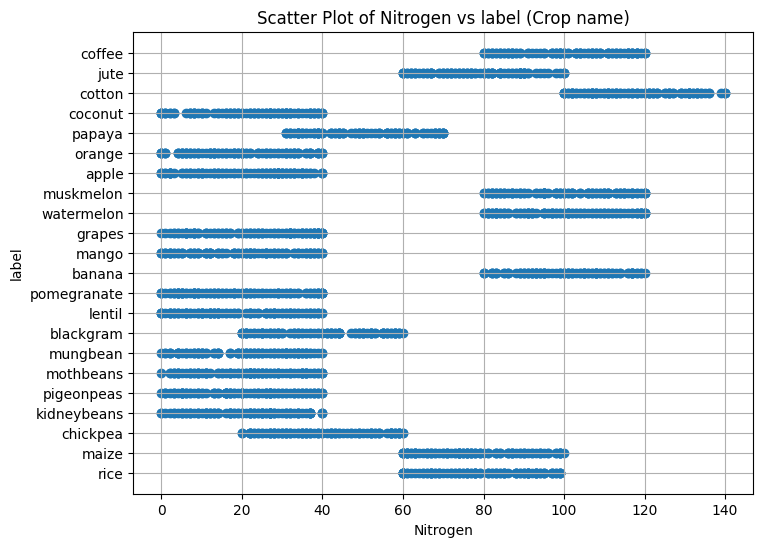

In [18]:
#Plotting covariance between Nitrogen and label
plt.figure(figsize=(8, 6))
plt.scatter(crop_df['N'], crop_df['label'])
plt.title('Scatter Plot of Nitrogen vs label (Crop name)')
plt.xlabel('Nitrogen')
plt.ylabel('label')
plt.grid(True)
plt.show()

**Observations: -**
* Soil having Nitrogen in range (0,40) has following crops: -
  1. coconut
  2. orange
  3. apple
  4. grapes
  5. mango
  6. pomegranate
  7. mungbean
  8. mothbeans
  9. pigeonpeas
      
* Soil having Nitrogen in range (20,60) has following crops: -
  1. chickpea
  2. blackgram
     
* Soil having Nitrogen in range (60,100) has following crops: -
  1. maize
  2. rice
  3. jute
     
* Soil having Nitrogen in range (80,120) has following crops: -
  1. coffee
  2. muskmellon
  3. watermellon
  4. banana
     
* Soil having Nitrogen in range (100,140) has following crops: -
  1. cotton

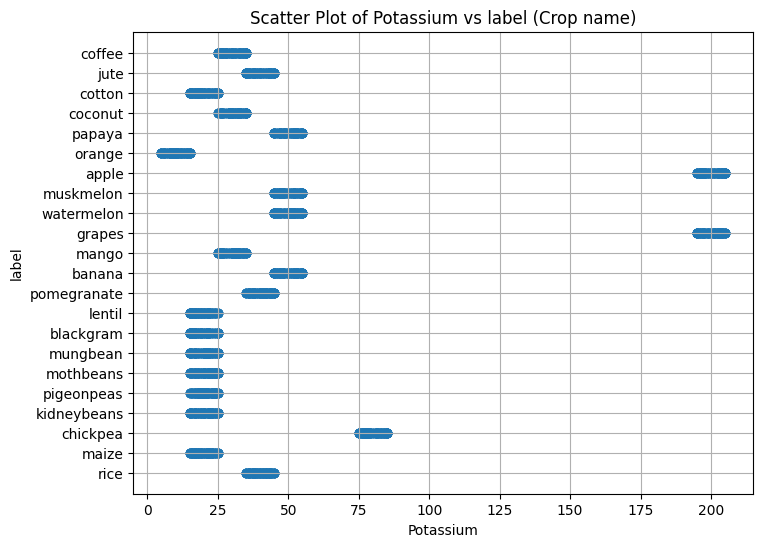

In [19]:
#Plotting covariance between Potassium and label
plt.figure(figsize=(8, 6))
plt.scatter(crop_df['K'], crop_df['label'])
plt.title('Scatter Plot of Potassium vs label (Crop name)')
plt.xlabel('Potassium')
plt.ylabel('label')
plt.grid(True)
plt.show()

**Observations: -**
* Soil having Potassium less than or equal to 25, following crops are suitable: -
  1. cotton
  2. orange
  3. lentil
  4. blackgram
  5. mungbean
  6. mothbeans
  7. pigeonpeas
  8. kidneybeans
  9. maize
      
* Soil having Potassium in range 25 to 50, following crops are suitable: -
  1. coffee
  2. jute
  3. coconut
  4. mango
  5. pomegranate
  6. rice
     
* Soil having Pottasium around 50, following crops are suitable: -
  1. papaya
  2. muskmelon
  3. watermelon
  4. banana
     
* Soil having Potassium in range 75 to 100, following crops are suitable: -
  1. chickpea
     
* Soil having Potassium around 200, following crops are suitable: -
  1. apple
  2. grapes

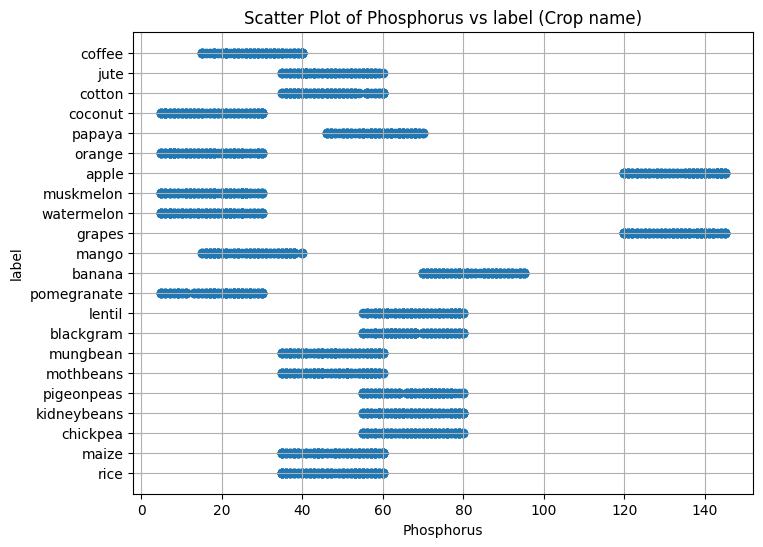

In [20]:
#Plotting covariance between Phosphorus and label
plt.figure(figsize=(8, 6))
plt.scatter(crop_df['P'], crop_df['label'])
plt.title('Scatter Plot of Phosphorus vs label (Crop name)')
plt.xlabel('Phosphorus')
plt.ylabel('label')
plt.grid(True)
plt.show()

Observations: -
* Soil having Phosphorus in range 0 to 40, following crops are suitable: -
  1. coffee
  2. coconut
  3. orange
  4. muskmellon
  5. watermellon
  6. mango
  7. pomegranate
     
* Soil having Phosphorus in range 40 to 60, following crops are suitable: -
  1. jute
  2. cotton
  3. papaya
  4. mungbean
  5. mothbeans
  6. maize
  7. rice
     
* Soil having Phosphorus in range 60 to 80, following crops are suitable: -
  1. papaya
  2. banana
  3. pomegranate
  4. lentil
  5. blackgram
  6. mothbeans
  7. pigeonpeas
  8. kidneybeans
     
* 

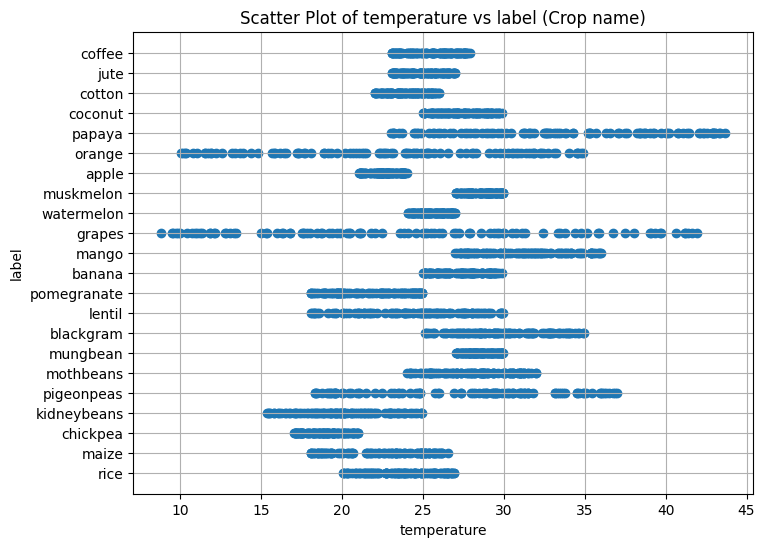

In [21]:
#Plotting covariance between temperature and label
plt.figure(figsize=(8, 6))
plt.scatter(crop_df['temperature'], crop_df['label'])
plt.title('Scatter Plot of temperature vs label (Crop name)')
plt.xlabel('temperature')
plt.ylabel('label')
plt.grid(True)
plt.show()

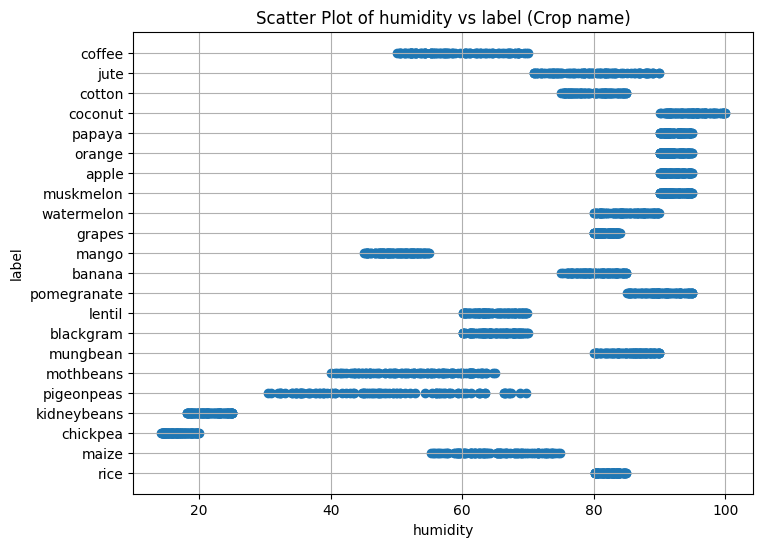

In [22]:
#Plotting covariance between humidity and label
plt.figure(figsize=(8, 6))
plt.scatter(crop_df['humidity'], crop_df['label'])
plt.title('Scatter Plot of humidity vs label (Crop name)')
plt.xlabel('humidity')
plt.ylabel('label')
plt.grid(True)
plt.show()

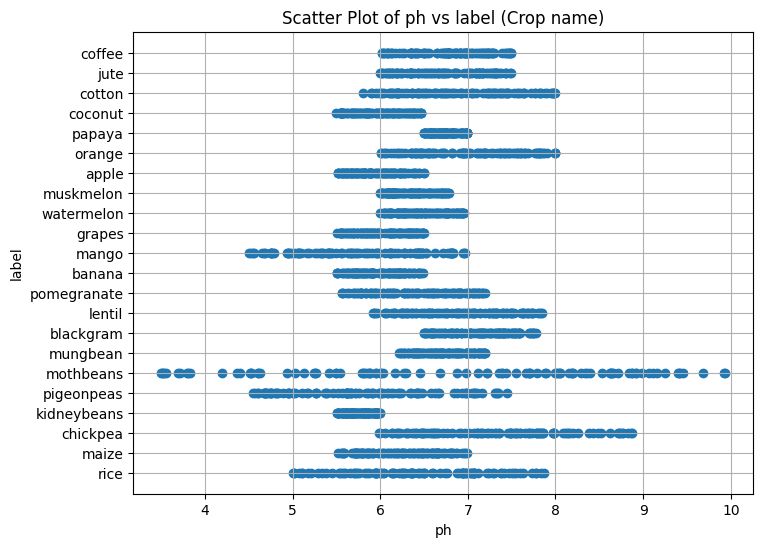

In [23]:
#Plotting covariance between ph and label
plt.figure(figsize=(8, 6))
plt.scatter(crop_df['ph'], crop_df['label'])
plt.title('Scatter Plot of ph vs label (Crop name)')
plt.xlabel('ph')
plt.ylabel('label')
plt.grid(True)
plt.show()

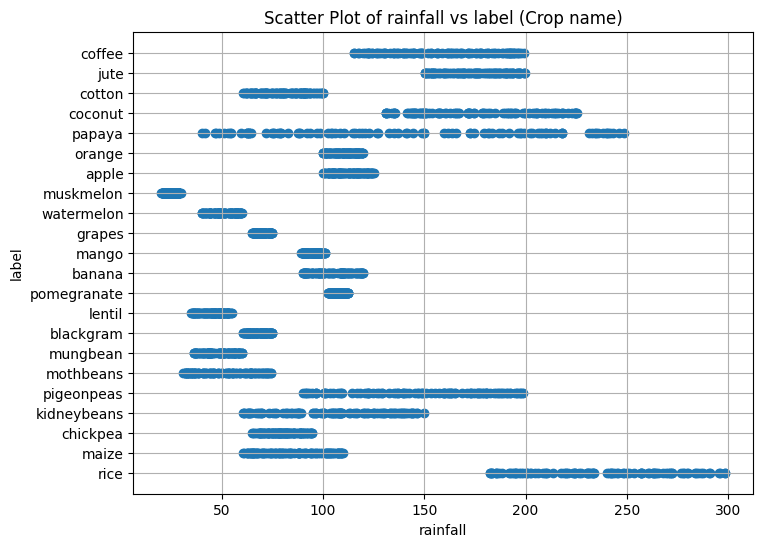

In [24]:
#Plotting covariance between rainfall and label
plt.figure(figsize=(8, 6))
plt.scatter(crop_df['rainfall'], crop_df['label'])
plt.title('Scatter Plot of rainfall vs label (Crop name)')
plt.xlabel('rainfall')
plt.ylabel('label')
plt.grid(True)
plt.show()

In [25]:
def plotting_normal_distribution(dataset_name, col_name):
    column_data=dataset_name[col_name]
    mu,sigma=column_data.mean(),column_data.std()
    x=np.linspace(mu - 4 * sigma, mu + 4 * sigma, 1000)
    pdf=norm.pdf(x, mu, sigma)
    plt.figure(figsize=(10, 6))
    plt.hist(column_data, bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')
    plt.plot(x, pdf, 'r-', lw=2, label=f'Normal Distribution (μ={mu:.2f}, σ={sigma:.2f})')
    plt.title(f'Normal Distribution Plot for Column: {col_name}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

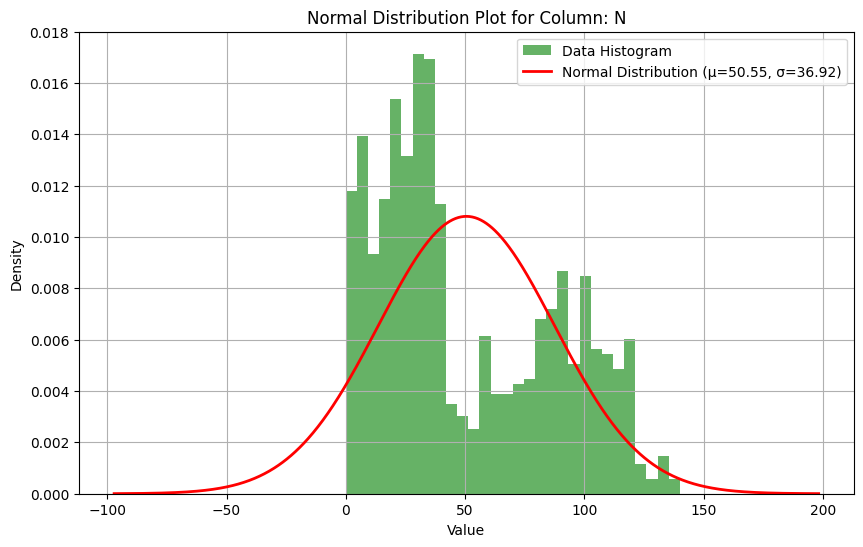

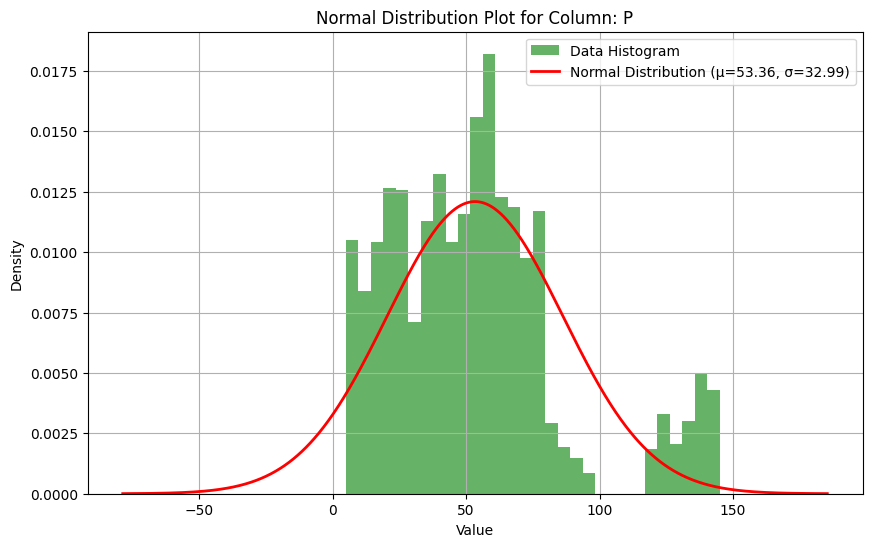

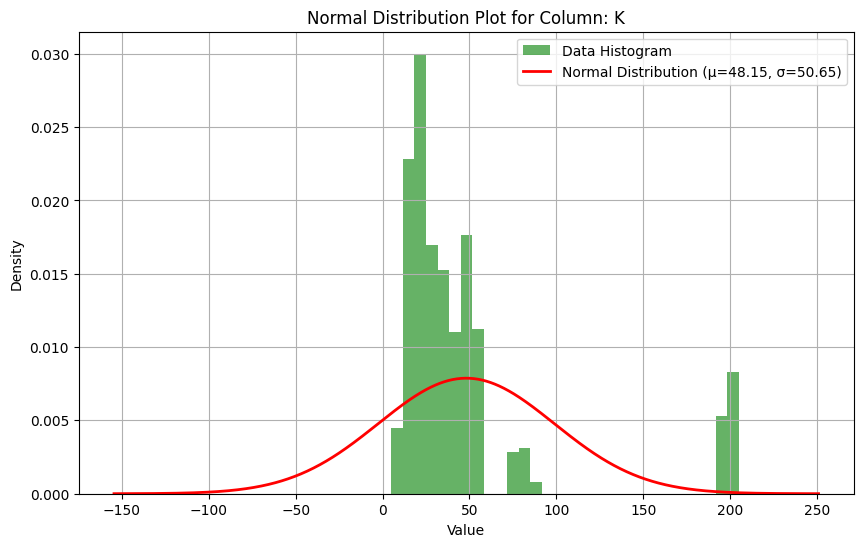

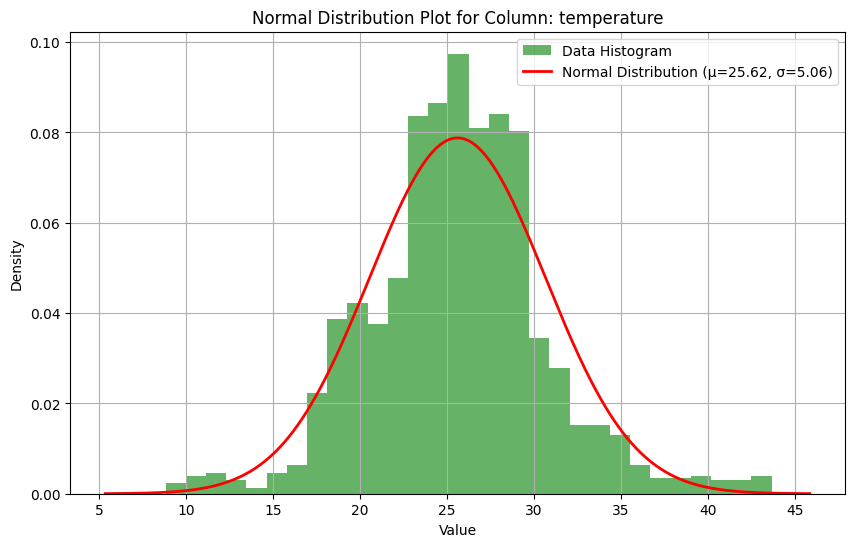

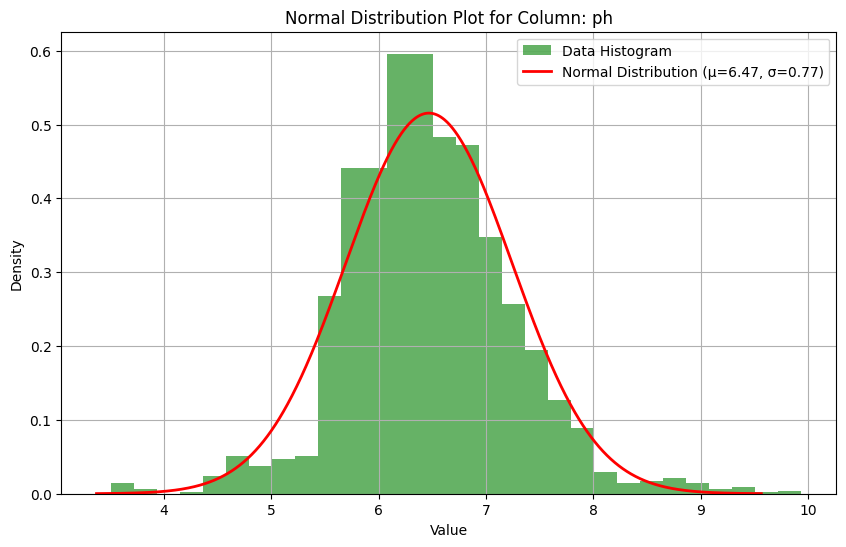

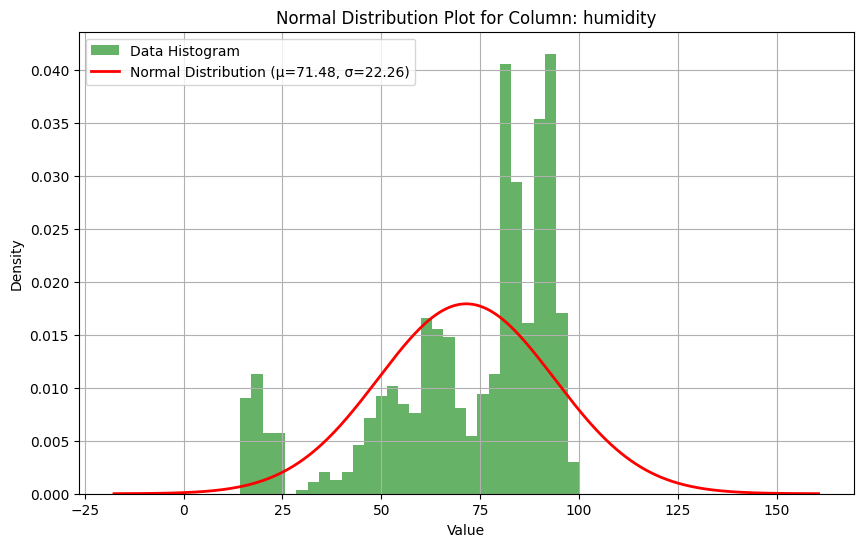

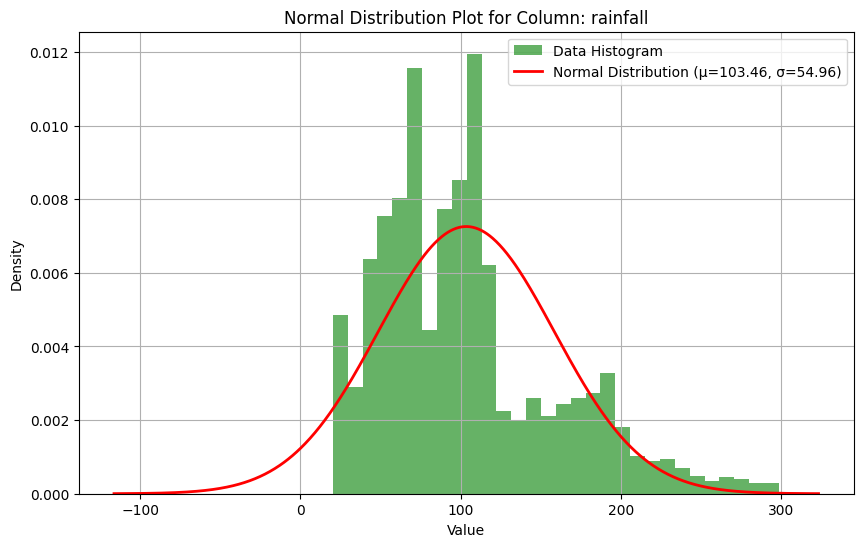

In [26]:
'''
Plotting Normal distribution for each independent feature, 
since all features are continuous
'''
plotting_normal_distribution(crop_df,'N')
plotting_normal_distribution(crop_df,'P')
plotting_normal_distribution(crop_df,'K')
plotting_normal_distribution(crop_df,'temperature')
plotting_normal_distribution(crop_df,'ph')
plotting_normal_distribution(crop_df,'humidity')
plotting_normal_distribution(crop_df,'rainfall')

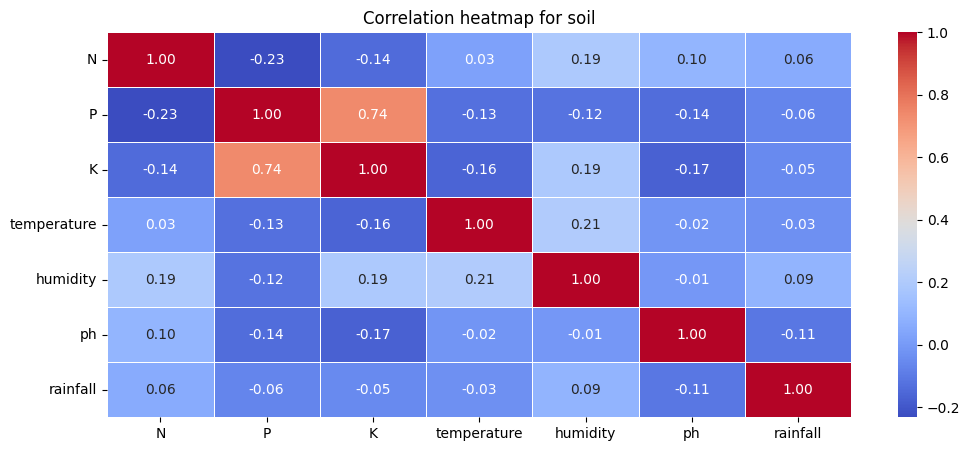

In [27]:
#Plotting correlation matrix
correlation_matrix=crop_df.corr(numeric_only=True)
plt.figure(figsize=(12,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidth=0.5)
plt.title("Correlation heatmap for soil")
plt.show()

**Observations from the above heatmap: -**

1. Phosphorus (P) and Potassium (K) have strong positive correlation. Their correlation value is 0.74

**Interpretation from above observation: -**

If Phosphorus content of soil increases then Potassium content of the soil has tendency to increase as well.

In [28]:
avg_N_by_crop=crop_df.groupby('label')['N'].mean().sort_values()
avg_N_by_crop

label
lentil          18.77
pomegranate     18.87
orange          19.58
mango           20.07
pigeonpeas      20.73
kidneybeans     20.75
apple           20.80
mungbean        20.99
mothbeans       21.44
coconut         21.98
grapes          23.18
blackgram       40.02
chickpea        40.09
papaya          49.88
maize           77.76
jute            78.40
rice            79.89
watermelon      99.42
banana         100.23
muskmelon      100.32
coffee         101.20
cotton         117.77
Name: N, dtype: float64

**We computed average amount of Nitrogen required in the soil per crop: -**
* 11 crops required average amount of Nitrogen in the range of 18 to 23 mm/Kg.
* 3 crops required average amount of Nitrogen in the range of 40 to 50 mm/Kg.
* 3 crops required average amount of Nitrogen in the range of 77 to 80 mm/Kg.
* 4 crops required average amount of Nitrogen greater than 100 mm/Kg.

In [29]:
avg_P_by_crop=crop_df.groupby('label')['P'].mean().sort_values()
avg_P_by_crop

label
orange          16.55
coconut         16.93
watermelon      17.00
muskmelon       17.72
pomegranate     18.75
mango           27.18
coffee          28.74
cotton          46.24
jute            46.86
mungbean        47.28
rice            47.58
mothbeans       48.01
maize           48.44
papaya          59.05
blackgram       67.47
kidneybeans     67.54
pigeonpeas      67.73
chickpea        67.79
lentil          68.36
banana          82.01
grapes         132.53
apple          134.22
Name: P, dtype: float64

**We computed average amount of Phosphorus required in the soil per crop: -**
* 7 crops required average amount of Phosphorus in the range of 16 to 28 mm/Kg.
* 6 crops required average amount of Phosphorus in the range of 46 to 49 mm/Kg.
* 7 crops required average amount of Phosphorus in the range of 61 to 83 mm/Kg.
* 2 crops required average amount of Phosphorus greater than 100 mm/Kg.

In [30]:
avg_K_by_crop=crop_df.groupby('label')['K'].mean().sort_values()
avg_K_by_crop

label
orange          10.01
blackgram       19.24
lentil          19.41
cotton          19.56
maize           19.79
mungbean        19.87
kidneybeans     20.05
mothbeans       20.23
pigeonpeas      20.29
mango           29.92
coffee          29.94
coconut         30.59
rice            39.87
jute            39.99
pomegranate     40.21
papaya          50.04
banana          50.05
muskmelon       50.08
watermelon      50.22
chickpea        79.92
apple          199.89
grapes         200.11
Name: K, dtype: float64

**We computed average amount of Potassium required in the soil per crop: -**
* 15 crops required average amount of Potassium in the range of 10 to 41 mm/Kg.
* 5 crops required average amount of Potassium in the range of 50 to 80 mm/Kg.
* 2 crops required average amount of Potassium greater than 199 mm/Kg.

In [31]:
avg_temperature_by_crop=crop_df.groupby('label')['temperature'].mean().sort_values()
avg_temperature_by_crop

label
chickpea       18.872847
kidneybeans    20.115085
pomegranate    21.837842
maize          22.389204
apple          22.630942
orange         22.765725
rice           23.689332
grapes         23.849575
cotton         23.988958
lentil         24.509052
jute           24.958376
coffee         25.540477
watermelon     25.591767
banana         27.376798
coconut        27.409892
pigeonpeas     27.741762
mothbeans      28.194920
mungbean       28.525775
muskmelon      28.663066
blackgram      29.973340
mango          31.208770
papaya         33.723859
Name: temperature, dtype: float64

**We computed average temperature required in the soil per crop: -**
* The average temperature range is 18 to 34 degree Celcius.

In [32]:
avg_humidity_by_crop=crop_df.groupby('label')['humidity'].mean().sort_values()
avg_humidity_by_crop

label
chickpea       16.860439
kidneybeans    21.605357
pigeonpeas     48.061633
mango          50.156573
mothbeans      53.160418
coffee         58.869846
lentil         64.804785
maize          65.092249
blackgram      65.118426
jute           79.639864
cotton         79.843474
banana         80.358123
grapes         81.875228
rice           82.272822
watermelon     85.160375
mungbean       85.499975
pomegranate    90.125504
orange         92.170209
apple          92.333383
muskmelon      92.342802
papaya         92.403388
coconut        94.844272
Name: humidity, dtype: float64

In [33]:
avg_ph_by_crop=crop_df.groupby('label')['ph'].mean().sort_values()
avg_ph_by_crop

label
kidneybeans    5.749411
mango          5.766373
pigeonpeas     5.794175
apple          5.929663
coconut        5.976562
banana         5.983893
grapes         6.025937
maize          6.245190
muskmelon      6.358805
rice           6.425471
pomegranate    6.429172
watermelon     6.495778
mungbean       6.723957
jute           6.732778
papaya         6.741442
coffee         6.790308
mothbeans      6.831174
cotton         6.912675
lentil         6.927932
orange         7.016957
blackgram      7.133952
chickpea       7.336957
Name: ph, dtype: float64

**We computed average amount of ph required in the soil per crop: -**
* 3 crops required soil ph around 7, which is neutral.
* Rest of the crops required soil ph less than 7, which is acidic.

In [34]:
avg_rainfall_by_crop=crop_df.groupby('label')['rainfall'].mean().sort_values()
avg_rainfall_by_crop

label
muskmelon       24.689952
lentil          45.680454
mungbean        48.403601
watermelon      50.786219
mothbeans       51.198487
blackgram       67.884151
grapes          69.611829
chickpea        80.058977
cotton          80.398043
maize           84.766988
mango           94.704515
banana         104.626980
kidneybeans    105.919778
pomegranate    107.528442
orange         110.474969
apple          112.654779
papaya         142.627839
pigeonpeas     149.457564
coffee         158.066295
jute           174.792798
coconut        175.686646
rice           236.181114
Name: rainfall, dtype: float64

**We computed average amount of rainfall required in the soil per crop: -**
* Rice requires most amount of rainfall.
* 11 crops require rainfall in the range of 24 to 95 mm.
* 6 crops require rainfall in the range of 101 to 113 mm.
* 5 crops require rainfall in the range of 142 to 176 mm.

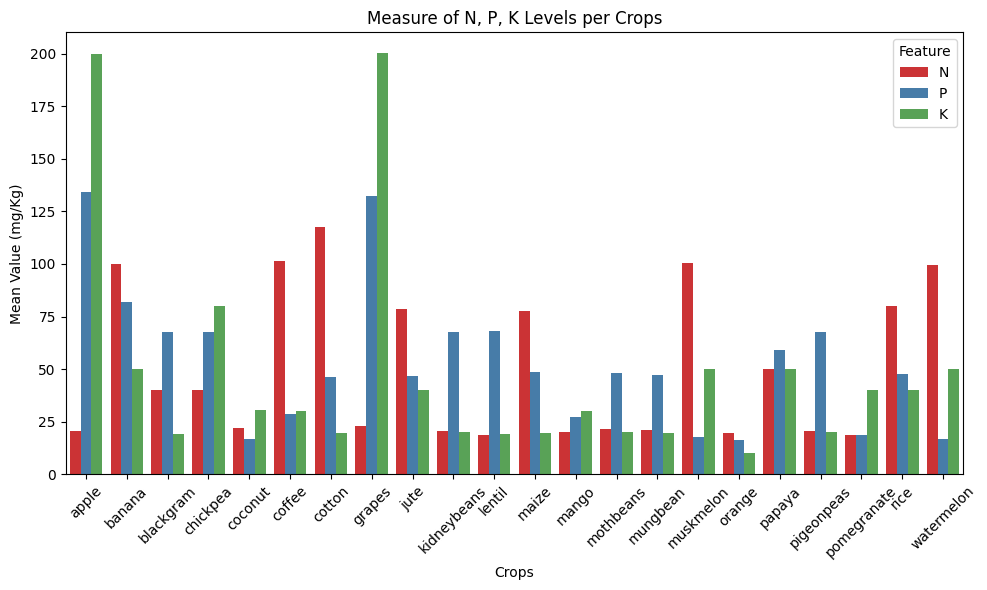

In [35]:
group_npk=crop_df.groupby("label")[["N", "P", "K"]].mean().reset_index()
melted=group_npk.melt(id_vars="label", value_vars=["N", "P", "K"],var_name="Feature", value_name="Mean Value")

plt.figure(figsize=(10,6))
sns.barplot(x="label", y="Mean Value", hue="Feature", data=melted, palette="Set1")
plt.title("Measure of N, P, K Levels per Crops")
plt.ylabel("Mean Value (mg/Kg)")
plt.xlabel("Crops")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

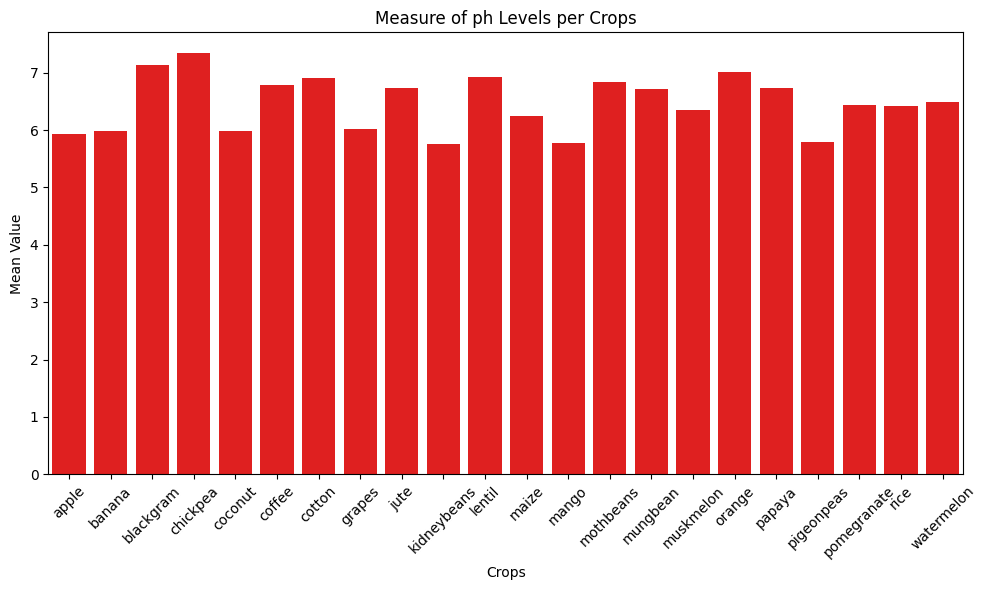

In [36]:
group_ph=crop_df.groupby("label")[["ph"]].mean().reset_index()
melted=group_ph.melt(id_vars="label", value_vars=["ph"],var_name="Feature", value_name="Mean Value")

plt.figure(figsize=(10,6))
sns.barplot(x="label", y="Mean Value", data=melted, color="red")
plt.title("Measure of ph Levels per Crops")
plt.ylabel("Mean Value")
plt.xlabel("Crops")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

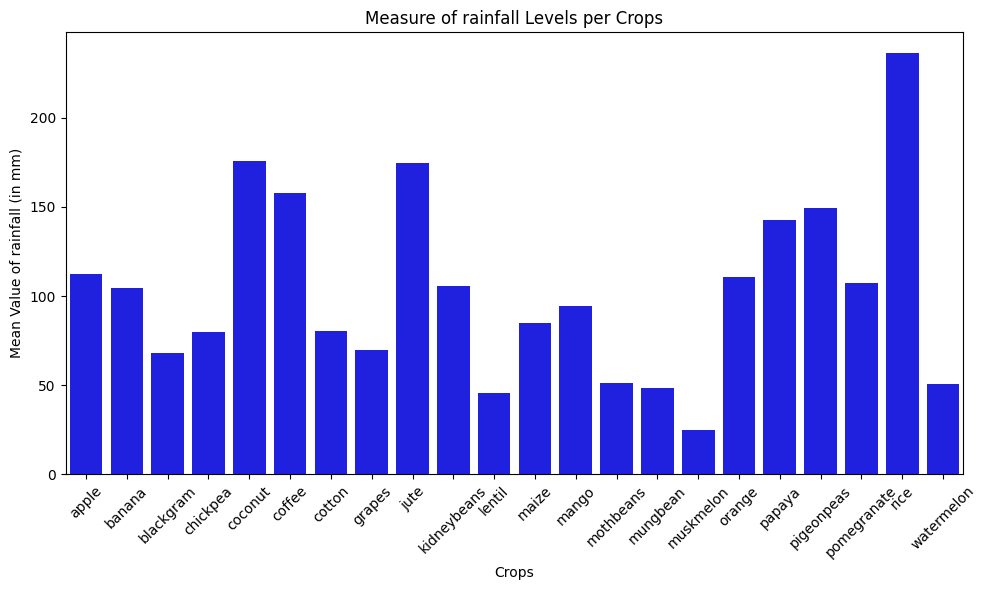

In [37]:
group_ph=crop_df.groupby("label")[["rainfall"]].mean().reset_index()
melted=group_ph.melt(id_vars="label", value_vars=["rainfall"],var_name="Feature", value_name="Mean Value")

plt.figure(figsize=(10,6))
sns.barplot(x="label", y="Mean Value", data=melted, color="blue")
plt.title("Measure of rainfall Levels per Crops")
plt.ylabel("Mean Value of rainfall (in mm)")
plt.xlabel("Crops")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Feature engineering

In [38]:
#Label encoding: Transformer to encode target values
label_encoder=preprocessing.LabelEncoder()
crop_df['label']=label_encoder.fit_transform(crop_df['label'])
crop_df['label'].unique()

array([20, 11,  3,  9, 18, 13, 14,  2, 10, 19,  1, 12,  7, 21, 15,  0, 16,
       17,  4,  6,  8,  5])

In [39]:
crop_df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,20


In [40]:
crop_df.tail()

,N,P,K,temperature,humidity,ph,rainfall,label
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,5
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,5
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,5
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,5
2199,104,18,30,23.603016,60.396475,6.779833,140.937041,5


# Splitting the dataset

In [41]:
X=crop_df.drop(["label"],axis=1)
y=crop_df["label"]

#Splitting the dataset such that 70% of the total data will be used for training the model
#Remaining 30% of the total data will be equally split between validation and test set.
X_train_temp,X_temp,y_train_temp,y_temp=train_test_split(X, y,test_size=0.3,random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)

In [42]:
#Training dataset
print("Printing first 5 rows: -\n")
print(X_train_temp.head())
print("Printing last 5 rows: -\n")
print(X_train_temp.tail())
print("Printing shape of X_train_temp: ",X_train_temp.shape)

#Training dataset
print("Printing first 5 rows: -\n")
print(y_train_temp.head())
print("Printing last 5 rows: -\n")
print(y_train_temp.tail())
print("Printing shape of X_train_temp: ",y_train_temp.shape)

Printing first 5 rows: -

       N   P   K  temperature   humidity        ph    rainfall
1102  21  26  27    27.003155  47.675254  5.699587   95.851183
1159  29  35  28    28.347161  53.539031  6.967418   90.402604
141   60  44  23    24.794708  70.045567  5.722580   76.728601
1004  80  77  49    26.054330  79.396545  5.519088  113.229737
2     60  55  44    23.004459  82.320763  7.840207  263.964248
Printing last 5 rows: -

        N    P    K  temperature   humidity        ph    rainfall
1638   10    5    5    21.213070  91.353492  7.817846  112.983436
1095  108   94   47    27.359116  84.546250  6.387431   90.812505
1130   11   36   31    27.920633  51.779659  6.475449  100.258567
1294   11  124  204    13.429886  80.066340  6.361141   71.400430
860    32   78   22    23.970814  62.355576  7.007038   53.409060
Printing shape of X_train_temp:  (1540, 7)
Printing first 5 rows: -

1102    12
1159    12
141     11
1004     1
2       20
Name: label, dtype: int64
Printing last 5 rows: -



In [43]:
#Validation dataset
print("Printing first 5 rows: -\n")
print(X_val.head())
print("Printing last 5 rows: -\n")
print(X_val.tail())
print("Printing shape of X_train_temp: ",X_val.shape)

#Training dataset
print("Printing first 5 rows: -\n")
print(y_val.head())
print("Printing last 5 rows: -\n")
print(y_val.tail())
print("Printing shape of X_train_temp: ",y_val.shape)

Printing first 5 rows: -

        N    P    K  temperature   humidity        ph    rainfall
1769   54   67   52    35.676673  93.306419  6.586107  141.338117
1322  120   19   49    25.794489  84.268307  6.762472   56.452292
679    31   40   22    29.408894  86.160635  6.365514   53.354870
1511   29  121  196    22.848528  94.321302  6.079497  123.597784
485    18   55   23    21.998983  56.310068  6.985720  136.827431
Printing last 5 rows: -

        N   P   K  temperature   humidity        ph    rainfall
1845   39   7  29    27.542732  94.590861  6.362544  150.201214
1391  100  10  53    24.543570  84.608083  6.211749   42.006603
998    39  24  39    23.653741  93.326575  6.431266  109.807618
59     99  55  35    21.723831  80.238990  6.501698  277.962619
1699   31  26   9    11.698946  93.256389  7.566166  103.200599
Printing shape of X_train_temp:  (330, 7)
Printing first 5 rows: -

1769    17
1322    21
679     14
1511     0
485     18
Name: label, dtype: int64
Printing last 5 rows

In [44]:
#Test dataset
print("Printing first 5 rows: -\n")
print(X_test.head())
print("Printing last 5 rows: -\n")
print(X_test.tail())
print("Printing shape of X_train_temp: ",X_test.shape)

#Training dataset
print("Printing first 5 rows: -\n")
print(y_test.head())
print("Printing last 5 rows: -\n")
print(y_test.tail())
print("Printing shape of X_train_temp: ",y_test.shape)

Printing first 5 rows: -

       N   P   K  temperature   humidity        ph    rainfall
1676  14  19  14    17.684088  94.358154  6.699165  108.063817
366   20  69  15    23.442607  22.772559  5.934136  107.413725
1615   9  11   8    24.859034  94.390005  6.559237  111.780373
931   34  21  42    18.759277  89.934576  6.648687  111.019674
100   71  54  16    22.613600  63.690706  5.749914   87.759539
Printing last 5 rows: -

       N    P    K  temperature   humidity        ph    rainfall
727   48   62   15    25.365861  66.637972  7.538631   65.816559
13    93   56   36    24.014976  82.056872  6.984354  185.277339
985   39   25   36    18.902230  94.998975  5.567805  107.610321
944   37   11   36    24.247796  85.560333  6.710143  106.921603
1281  35  125  204    19.649177  80.152158  6.107742   73.695296
Printing shape of X_train_temp:  (330, 7)
Printing first 5 rows: -

1676    16
366      9
1615    16
931     19
100     11
Name: label, dtype: int64
Printing last 5 rows: -

727    

# Normalization of dataset

In [45]:
#Normalizing the values
standard_scaler=preprocessing.StandardScaler()
X_train_temp=standard_scaler.fit_transform(X_train_temp)
X_val=standard_scaler.fit_transform(X_val)
X_test=standard_scaler.fit_transform(X_test)

# Training the model

In [46]:
#Training the model using all features of dataset with Random Forest
rf_classifier_1=RandomForestClassifier(n_estimators=100,random_state=42)
rf_classifier_1.fit(X_train_temp,y_train_temp)
y_pred_val_1=rf_classifier_1.predict(X_val)
#Evaluating the model om validation dataset
classification_rep=classification_report(y_val, y_pred_val_1)
print("\nClassification Report:\n", classification_rep)
accuracy=accuracy_score(y_val, y_pred_val_1)
f1=f1_score(y_val, y_pred_val_1, average='macro')  
precision=precision_score(y_val, y_pred_val_1, average='macro')
recall=recall_score(y_val, y_pred_val_1, average='macro')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15
           2       1.00      0.62      0.77        16
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        11
           8       0.81      1.00      0.89        17
           9       1.00      1.00      1.00        14
          10       0.69      1.00      0.81        11
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        11
          13       0.95      1.00      0.98        20
          14       1.00      1.00      1.00        16
          15       1.00      1.00      1.00        13
          16       1.00      1.00      1.00        13
  

In [47]:
#Training the model by dropping rainfall from dataset with Random Forest
X_train_temp_2=np.delete(X_train_temp, [6], axis=1)
X_val_2=np.delete(X_val, [6], axis=1)
rf_classifier_2=RandomForestClassifier(n_estimators=100,random_state=42)
rf_classifier_2.fit(X_train_temp_2,y_train_temp)
y_pred_val_2=rf_classifier_2.predict(X_val_2)
#Evaluating the model om validation dataset
classification_rep=classification_report(y_val, y_pred_val_2)
print("\nClassification Report:\n", classification_rep)
accuracy=accuracy_score(y_val, y_pred_val_2)
f1=f1_score(y_val, y_pred_val_2, average='macro')  
precision=precision_score(y_val, y_pred_val_2, average='macro')
recall=recall_score(y_val, y_pred_val_2, average='macro')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15
           2       0.92      0.75      0.83        16
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        11
           8       0.83      0.88      0.86        17
           9       1.00      1.00      1.00        14
          10       0.71      0.91      0.80        11
          11       1.00      1.00      1.00        10
          12       1.00      0.91      0.95        11
          13       0.80      1.00      0.89        20
          14       1.00      1.00      1.00        16
          15       1.00      1.00      1.00        13
          16       1.00      1.00      1.00        13
  

In [48]:
#Training the model by dropping Phosphorus from dataset with Random Forest
X_train_temp_3=np.delete(X_train_temp, [1], axis=1)
X_val_3=np.delete(X_val, [1], axis=1)
rf_classifier_3=RandomForestClassifier(n_estimators=100,random_state=42)
rf_classifier_3.fit(X_train_temp_3,y_train_temp)
y_pred_val_3=rf_classifier_3.predict(X_val_3)
#Evaluating the model om validation dataset
classification_rep=classification_report(y_val, y_pred_val_3)
print("\nClassification Report:\n", classification_rep)
accuracy=accuracy_score(y_val, y_pred_val_3)
f1=f1_score(y_val, y_pred_val_3, average='macro')  
precision=precision_score(y_val, y_pred_val_3, average='macro')
recall=recall_score(y_val, y_pred_val_3, average='macro')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15
           2       0.92      0.69      0.79        16
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        11
           8       0.81      1.00      0.89        17
           9       1.00      1.00      1.00        14
          10       0.62      0.91      0.74        11
          11       1.00      1.00      1.00        10
          12       0.92      1.00      0.96        11
          13       1.00      0.90      0.95        20
          14       1.00      1.00      1.00        16
          15       0.93      1.00      0.96        13
          16       1.00      1.00      1.00        13
  

In [49]:
#Training the model by dropping Potassium from dataset with Random Forest
X_train_temp_4=np.delete(X_train_temp, [2], axis=1)
X_val_4=np.delete(X_val, [2], axis=1)
rf_classifier_4=RandomForestClassifier(n_estimators=100,random_state=42)
rf_classifier_4.fit(X_train_temp_4,y_train_temp)
y_pred_val_4=rf_classifier_4.predict(X_val_4)
#Evaluating the model om validation dataset
classification_rep=classification_report(y_val, y_pred_val_4)
print("\nClassification Report:\n", classification_rep)
accuracy=accuracy_score(y_val, y_pred_val_4)
f1=f1_score(y_val, y_pred_val_4, average='macro')  
precision=precision_score(y_val, y_pred_val_4, average='macro')
recall=recall_score(y_val, y_pred_val_4, average='macro')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15
           2       1.00      0.62      0.77        16
           3       1.00      0.92      0.96        13
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        15
           6       1.00      0.93      0.97        15
           7       1.00      1.00      1.00        11
           8       0.85      1.00      0.92        17
           9       1.00      1.00      1.00        14
          10       0.65      1.00      0.79        11
          11       0.91      1.00      0.95        10
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00        20
          14       0.94      1.00      0.97        16
          15       1.00      1.00      1.00        13
          16       0.86      0.92      0.89        13
  

**Model 1: Using all features**
* Accuracy=0.97
* Precision=0.97
* Recall=0.97
* F1-Score=0.97
  
**Model 2: Dropped rainfall**
* Accuracy=0.95
* Precision=0.96
* Recall=0.95
* F1-Score=0.95

**Model 3: Dropped Phosphorus**
* Accuracy=0.96
* Precision=0.96
* Recall=0.96
* F1-Score=0.96

**Model 4: Dropped Potassium**
* Accuracy=0.95
* Precision=0.96
* Recall=0.96
* F1-Score=0.95

From the above results computed on Validation dataset, we observed that Random Forest classifier worked best when all features from the dataset were used to train the model.

# Evaluating the model

In [50]:
#Testing the results using Model 1: Model trained with all features
y_pred=rf_classifier_1.predict(X_test)
#Evaluating the model om validation dataset
classification_rep=classification_report(y_test, y_pred)
print("\nClassification Report:\n", classification_rep)
accuracy=accuracy_score(y_test, y_pred)
f1=f1_score(y_test, y_pred, average='macro')  
precision=precision_score(y_test, y_pred, average='macro')
recall=recall_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        11
           2       1.00      0.80      0.89        10
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        20
           5       1.00      0.87      0.93        15
           6       0.81      1.00      0.90        13
           7       1.00      1.00      1.00        12
           8       0.81      1.00      0.89        17
           9       1.00      0.36      0.53        22
          10       0.73      1.00      0.85        11
          11       1.00      0.81      0.90        16
          12       1.00      1.00      1.00        21
          13       0.75      0.86      0.80        14
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        11
          16       1.00      1.00      1.00        12
  